# RF forward modelling of sedimentary layers

In [1]:
from BayHunter.SynthObs import SynthObs
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [2]:
h = [5, 23, 8, 10]
vs = [2.7, 3.6, 3.8, 4.4]
vpvs = 1.73

start = -5
stop = 35
duration = stop - start
sampling_rate = 50  # Hz
x = np.linspace(start, stop, duration * sampling_rate)
rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)

In [3]:
def layers_to_points(layer_thicks, layer_velocities):
    """
    Converts thicknesses to depths
    Repeats arrays for plotting purposes
    """
    layer_depths = np.cumsum(layer_thicks) ## THIS IS WRONG
    layer_depths = np.concatenate(([0], layer_depths))
    if layer_depths[-1] == layer_depths[-2]:  # thickness of last layer was 0
        layer_depths[-1] += 10  # pad for the mantle
    z = np.repeat(layer_depths, 2)[1:-1]
    vs = np.repeat(layer_velocities, 2)
    return z, vs

def plot_1d_profile(layer_thicks, layer_velocities, ax=None):
    if ax is None:
        ax = plt.axes()
    z, vs = layers_to_points(layer_thicks, layer_velocities)
    ax.plot(vs, z)
    ax.invert_yaxis()
    ax.set_xlabel("$v_s$ (km/h)")
    ax.set_ylabel("Depth (km)")

def plot_rf(rfdata, ax=None):
    """
    rfdata is the output of SythObs.return_rfdata
    This will plot the P RF
    """
    if ax is None:
        ax =plt.axes()
    ax.plot(rfdata["prf"][0], rfdata["prf"][1])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("P RF")
    ax.set_yticklabels([])

def plot_synthetic(layer_thicks, layer_velocities, rfdata, gs=None):
    if gs is None:
        fig = plt.figure(layout="tight")
        gs = GridSpec(3, 4, figure=fig)
    else:
        fig = gs.figure
    ax = fig.add_subplot(gs[:, 0])
    plot_1d_profile(layer_thicks, layer_velocities, ax=ax)
    ax = fig.add_subplot(gs[1, 1:])
    plot_rf(rfdata, ax=ax)

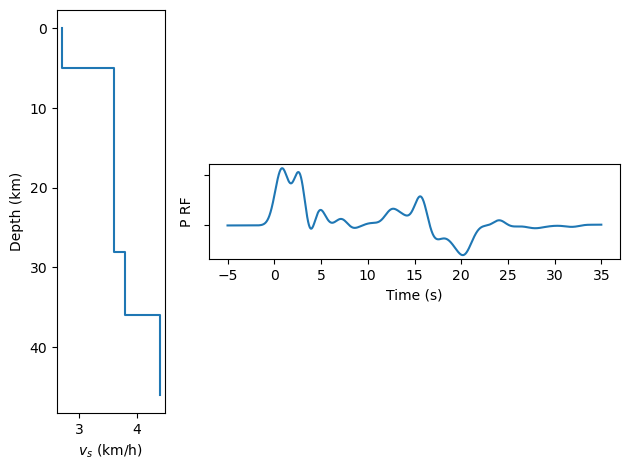

In [4]:
fig = plot_synthetic(h, vs, rfdata)

Get an average [AuSREM](http://rses.anu.edu.au/seismology/AuSREM/Downloads/downloads.php#) model

In [5]:
moho = np.loadtxt("../data/AuSREM/AusMoho2012.xyz", usecols=-1).mean()
crust = np.loadtxt("../data/AuSREM/AuSREM-C-int5km.txt", skiprows=15, comments="depth")
crust_z = np.sort(np.concatenate([[moho], np.unique(crust[:,0])]))
crust_h = crust_z[1:] - crust_z[:-1]
crust_h = np.concatenate([crust_h, [0]])
crust_vs = np.array([crust[crust[:, 0] == z, 4].mean() for z in crust_z if z < moho])
mantle = np.loadtxt("../data/AuSREM/AM4-int25km_Nov.txt", usecols=[0, 4], skiprows=17, comments="depth")
mantle_vs = mantle[mantle[:, 0] > moho, 1].mean()

ausrem_h = crust_z[1:] - crust_z[:-1]
ausrem_vs = np.concatenate([crust_vs, np.full(ausrem_h.size - crust_vs.size, mantle_vs)])

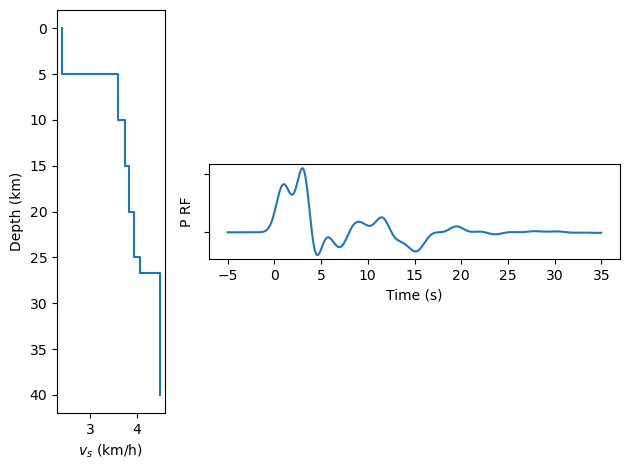

In [6]:
rfdata = SynthObs.return_rfdata(ausrem_h, ausrem_vs, vpvs=vpvs, x=x)
plot_synthetic(ausrem_h, ausrem_vs, rfdata)

In [7]:
def add_sediment_layer(h, vs, dtb):
    """
    h (km) and vs (km/h) are the thicknesses and velocities of a 1D model
    Assuming the top of the first layer is the basement, dtb is the depth
    to basement i.e. sedimentary thickness in km
    """
    sediment_velocity = 0.5  # get a ref for this
    upper_crust_h = h[0] - dtb
    h = np.concatenate([[dtb, upper_crust_h], h[1:]])
    vs = np.concatenate([[sediment_velocity], vs])
    return h, vs

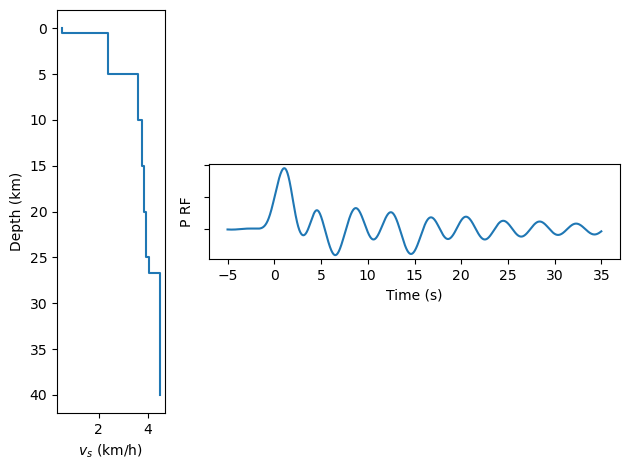

In [8]:
h, vs = add_sediment_layer(ausrem_h, ausrem_vs, 0.5)
rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)
plot_synthetic(h, vs, rfdata)

(0.0, 4.75687843921961)

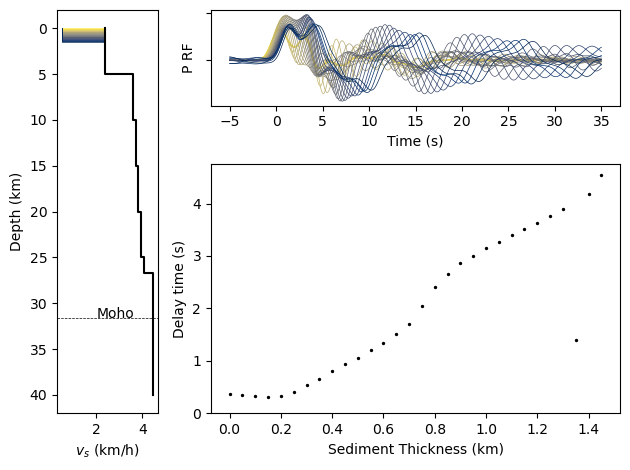

In [9]:
fig = plt.figure(layout="tight")
gs = GridSpec(3, 4, figure=fig)
model_ax = fig.add_subplot(gs[:, 0])
z, vs = layers_to_points(ausrem_h, ausrem_vs)
model_ax.plot(vs, z, "k", zorder=100)
model_ax.axhline(moho, c="k", linestyle="--", linewidth=0.5)
model_ax.text(2, moho, "Moho")
model_ax.invert_yaxis()
model_ax.set_xlabel("$v_s$ (km/h)")
model_ax.set_ylabel("Depth (km)")

rf_ax = fig.add_subplot(gs[0, 1:])
rf_ax.set_xlabel("Time (s)")
rf_ax.set_ylabel("P RF")
rf_ax.set_yticklabels([])

delays_ax = fig.add_subplot(gs[1:, 1:])
delays_ax.set_xlabel("Sediment Thickness (km)")
delays_ax.set_ylabel("Delay time (s)")

delays = []
sed_thicks = np.arange(1.5, step=0.05)
cmap = cm.cividis_r(np.linspace(0, 1, len(sed_thicks)))
for i, sed_thick in enumerate(sed_thicks):
    h, vs = add_sediment_layer(ausrem_h, ausrem_vs, sed_thick)
    rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)

    layer_depths = np.cumsum(h)
    layer_depths = np.concatenate(([0], layer_depths))
    z = np.repeat(layer_depths, 2)[1:-1]
    vs = np.repeat(vs, 2)
    model_ax.plot(vs, z, c=cmap[i], linewidth=0.5)
    rf_ax.plot(x, rfdata["prf"][1], c=cmap[i], linewidth=0.5)

    delays.append(x[np.argmax(rfdata["prf"][1])])

delays_ax.scatter(sed_thicks, delays, s=2, c="k")
delays_ax.set_ylim(bottom=0)


Simple two-layer model, using Brocher relations to get vpvs

In [10]:
sed_velocity = 1
crust_velocity = np.array([crust[crust[:, 0] == z, 4].mean() for z in crust_z if z < moho]).mean()
mantle_velocity = mantle[mantle[:, 0] > moho, 1].mean()
vs = np.array([sed_velocity, crust_velocity, mantle_velocity])

def brocher(vs):
    return 0.9409 + 2.0947 * vs - 0.8206 * vs**2 + 0.2683 * vs**3 - 0.0251 * vs**4

vpvs = brocher(vs) / vs

In [11]:
def get_tpsb(rrf, t):
    """
    rrf = radial receiver function
    t = time samples
    """
    return t[np.argmax(rrf)]

def get_autocorrelation(rrf, positive_only=True):
    autocorrelation = np.correlate(rrf, rrf, mode='full')
    autocorrelation /= np.max(autocorrelation)
    return autocorrelation[len(autocorrelation) // 2:] if positive_only else autocorrelation
    

def get_two_way_traveltime(autocorrelation, sr):
    """
    Find first local minimum of autocorrelation.
    Autocorrelation will always have a negative gradient to start with.
    So the first point where the gradient becomes positive is 
    (close enough to) the first stationary point.

    autocorrelation = radial receiver function autocorrelation
    sr = sampling rate (Hz)
    """
    ind = np.where(np.gradient(autocorrelation) >= 0)[0][0]
    # ind = np.argmin(autocorrelation)
    r0 = -(autocorrelation[ind])
    Dt = ind / sr

    return Dt

In [12]:
def figure_layout():
    fig = plt.figure(layout="tight")
    gs0 = GridSpec(1, 2, figure=fig, width_ratios={1, 3})
    gs00 = gs0[0].subgridspec(1, 1)
    model_ax = fig.add_subplot(gs00[:, 0])
    model_ax.invert_yaxis()
    model_ax.set_xlabel("$v_s$ (km/s)", labelpad=0)
    model_ax.set_ylabel("Depth (km)")

    gs01 = gs0[1].subgridspec(2, 1)

    gs010 = gs01[0].subgridspec(2, 1, hspace=0)
    rf_ax = fig.add_subplot(gs010[0])
    rf_ax.set_xticks([], [])
    rf_ax.set_yticks([], [])
    rf_ax.set_ylabel("P RF")
    auto_ax = fig.add_subplot(gs010[1])
    auto_ax.set_xlabel("Time (s)", labelpad=0)
    auto_ax.set_ylabel("Autocorrelation")
    auto_ax.set_yticks([], [])

    gs011 = gs01[1].subgridspec(2, 1, hspace=0, height_ratios={9, 1})
    delay_ax = fig.add_subplot(gs011[0])
    delay_ax.set_xticks([], [])
    delay_colour = "r"
    delay_ax.set_ylabel("Delay time (s)", color=delay_colour)
    delay_ax.tick_params(axis="y", labelcolor=delay_colour)
    tt_ax = delay_ax.twinx()
    tt_colour = "b"
    tt_ax.set_ylabel("Two-way traveltime (s)", color=tt_colour)
    tt_ax.tick_params(axis="y", labelcolor=tt_colour)

    cbar_ax = fig.add_subplot(gs011[1])
    cbar_ax.spines[["bottom", "left", "right"]].set_visible(False)

    return fig

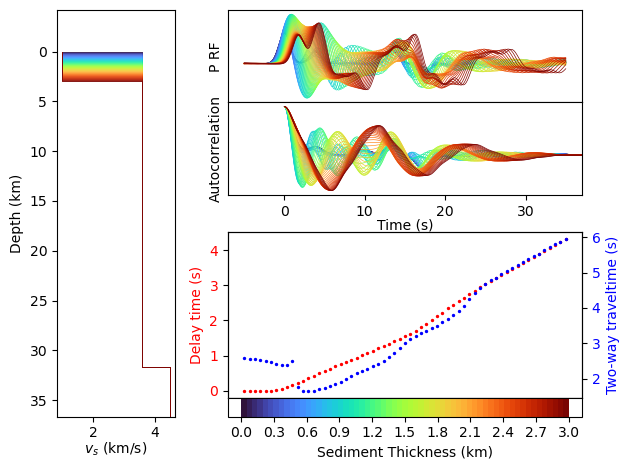

In [13]:
fig = figure_layout()
model_ax, rf_ax, auto_ax, delay_ax, tt_ax, cbar_ax = fig.axes

start = -5
stop = 35
duration = stop - start
sampling_rate = 50  # Hz
x = np.linspace(start, stop, duration * sampling_rate) # axis for the rf
t = x - start # axis for the autocorrelation
delays = []
travel_times = []
thickest = 3
step = 0.05
sed_thicks = np.arange(thickest + step, step=step)
cmap = cm.turbo(np.linspace(0, 1, len(sed_thicks)))
for i, sed_thick in enumerate(sed_thicks):
    h = [sed_thick, moho - sed_thick, moho + 20]
    rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)["prf"][1]
    autocorrelation = get_autocorrelation(rfdata)

    _z, _vs = layers_to_points(h, vs)
    model_ax.plot(_vs, _z, c=cmap[i], linewidth=0.5)
    rf_ax.plot(x, rfdata, c=cmap[i], linewidth=0.5)
    auto_ax.plot(t, autocorrelation, c=cmap[i], linewidth=0.5)

    delays.append(get_tpsb(rfdata, x))
    travel_times.append(get_two_way_traveltime(autocorrelation, sampling_rate))

model_ax.set_ylim(bottom=moho + 5)
auto_ax.set_xlim(rf_ax.get_xlim())

delay_ax.scatter(sed_thicks, delays, s=2, c=delay_ax.axes.yaxis.label._color)
tt_ax.scatter(sed_thicks, travel_times, s=2, c=tt_ax.axes.yaxis.label._color)

cmap = LinearSegmentedColormap.from_list("cmap", cmap, N=sed_thicks.size)
cbar = fig.colorbar(
    cm.ScalarMappable(norm=Normalize(0, thickest), cmap=cmap),
    cax=cbar_ax,
    orientation="horizontal",
    label="Sediment Thickness (km)",
    pad=0,
    shrink=0.95
)
cbar_ax.set_xticks(np.arange(0, thickest+0.3, step=0.3))
_xmn, _xmx = delay_ax.get_xlim()
cbar_ax.set_xlim([_xmn + 0.03, _xmx - 0.03])
plt.show()

Text(0, 0.5, '2way traveltime')

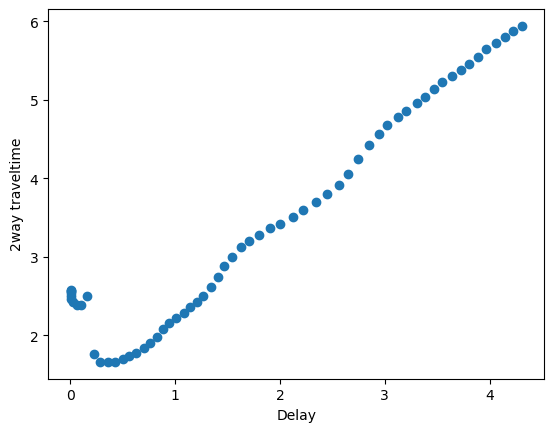

In [14]:
plt.scatter(delays, travel_times)
plt.xlabel("Delay")
plt.ylabel("2way traveltime")

Sediment compaction model for $v_s$ from [Cunningham & Lekic, 2020](https://doi.org/10.1785/0120190191) (eq 8)

$$v_s(z) = v_0 + az^p$$

$p=0.5$ implies linear increase in shear rigidity ($\mu$) with depth $z$

Their best fitting model had $v_0=100$ m/s and $a=55$ ($z$ in meters)

In [15]:
def sediment_compaction(z, a, v0, p=0.5):
    return a * z ** p + v0

Need to choose $a$ and $v_0$ such that there is still a jump in velocity at the sediment basement

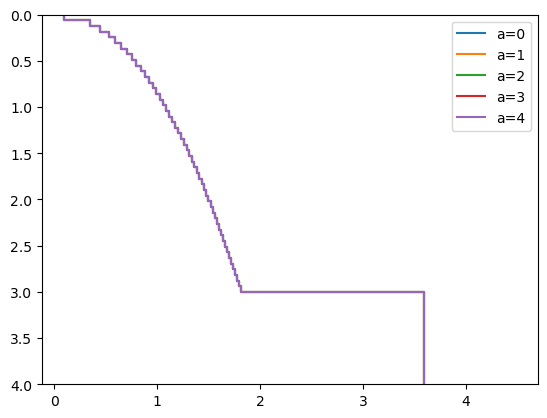

In [16]:
sed_thick = 3
sed_z = np.linspace(0, sed_thick, 50) # depths

for a in np.arange(5):
    sed_velocity = sediment_compaction(sed_z, 1, 0.1) # velocity at each point
    sed_h = sed_z[1:] - sed_z[:-1] # layer thickness
    sed_velocity = sed_velocity[:-1] # layer velocities
    h = sed_h.tolist() + [moho - sed_thick, moho + 20]
    vs = np.concatenate([sed_velocity, np.array([crust_velocity, mantle_velocity])])
    _z, _vs = layers_to_points(h, vs)

    plt.plot(_vs, _z, label=f"a={a}")
plt.ylim([0,sed_thick + 1])
plt.legend()
(plt.gca()).invert_yaxis()

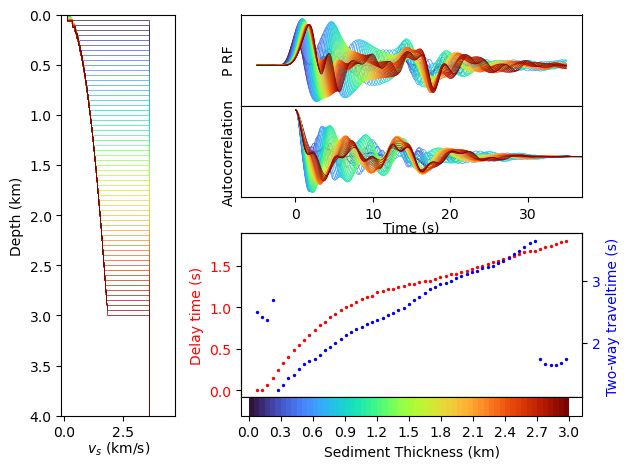

In [17]:
fig = figure_layout()
model_ax, rf_ax, auto_ax, delay_ax, tt_ax, cbar_ax = fig.axes

start = -5
stop = 35
duration = stop - start
sampling_rate = 50  # Hz
x = np.linspace(start, stop, duration * sampling_rate) # axis for the rf
t = x - start # axis for the autocorrelation
delays = []
travel_times = []
thickest = 3
step = 0.05
sed_thicks = np.arange(thickest + step, step=step)[1:]
cmap = cm.turbo(np.linspace(0, 1, len(sed_thicks)))
for i, sed_thick in enumerate(sed_thicks):
    sed_z = np.linspace(0, sed_thick, 50) # depths
    sed_velocity = sediment_compaction(sed_z, 1, 0.1) # velocity at each point
    sed_h = sed_z[1:] - sed_z[:-1] # layer thickness
    sed_velocity = sed_velocity[:-1] # layer velocities
    h = sed_h.tolist() + [moho - sed_thick, moho + 20]
    vs = np.concatenate([sed_velocity, np.array([crust_velocity, mantle_velocity])])
    vpvs = brocher(vs) / vs

    rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)["prf"][1]
    autocorrelation = get_autocorrelation(rfdata)

    _z, _vs = layers_to_points(h, vs)
    model_ax.plot(_vs, _z, c=cmap[i], linewidth=0.5)
    rf_ax.plot(x, rfdata, c=cmap[i], linewidth=0.5)
    auto_ax.plot(t, autocorrelation, c=cmap[i], linewidth=0.5)

    delays.append(get_tpsb(rfdata, x))
    travel_times.append(get_two_way_traveltime(autocorrelation, sampling_rate))

model_ax.set_ylim(top=0, bottom=4)
auto_ax.set_xlim(rf_ax.get_xlim())

delay_ax.scatter(sed_thicks, delays, s=2, c=delay_ax.axes.yaxis.label._color)
tt_ax.scatter(sed_thicks, travel_times, s=2, c=tt_ax.axes.yaxis.label._color)

cmap = LinearSegmentedColormap.from_list("cmap", cmap, N=sed_thicks.size)
cbar = fig.colorbar(
    cm.ScalarMappable(norm=Normalize(0, thickest), cmap=cmap),
    cax=cbar_ax,
    orientation="horizontal",
    label="Sediment Thickness (km)",
    pad=0,
    shrink=0.95
)
cbar_ax.set_xticks(np.arange(0, thickest+0.3, step=0.3))
_xmn, _xmx = delay_ax.get_xlim()
cbar_ax.set_xlim([_xmn + 0.03, _xmx - 0.03])
plt.show()

Text(0, 0.5, '2way traveltime')

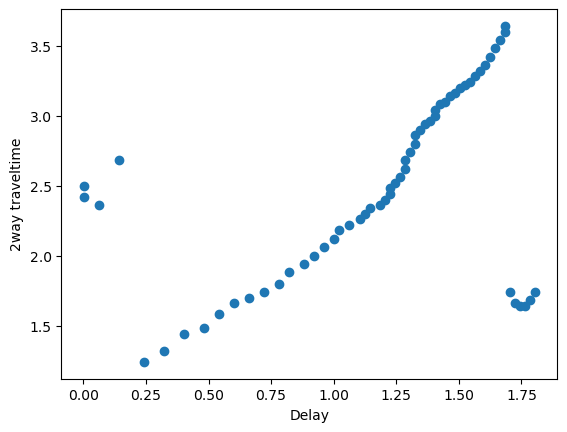

In [18]:
plt.scatter(delays, travel_times)
plt.xlabel("Delay")
plt.ylabel("2way traveltime")

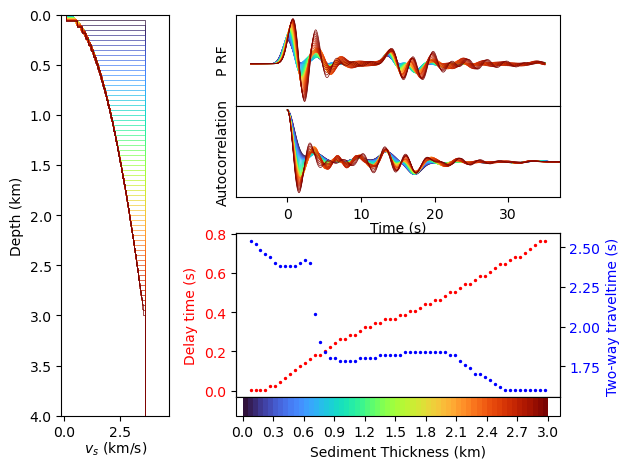

In [19]:
fig = figure_layout()
model_ax, rf_ax, auto_ax, delay_ax, tt_ax, cbar_ax = fig.axes

start = -5
stop = 35
duration = stop - start
sampling_rate = 50  # Hz
x = np.linspace(start, stop, duration * sampling_rate) # axis for the rf
t = x - start # axis for the autocorrelation
delays = []
travel_times = []
thickest = 3
step = 0.05
sed_thicks = np.arange(thickest + step, step=step)[1:]
cmap = cm.turbo(np.linspace(0, 1, len(sed_thicks)))
for i, sed_thick in enumerate(sed_thicks):
    sed_z = np.linspace(0, sed_thick, 50) # depths
    sed_velocity = sediment_compaction(sed_z, 2, 0.1) # velocity at each point
    sed_h = sed_z[1:] - sed_z[:-1] # layer thickness
    sed_velocity = sed_velocity[:-1] # layer velocities
    h = sed_h.tolist() + [moho - sed_thick, moho + 20]
    vs = np.concatenate([sed_velocity, np.array([crust_velocity, mantle_velocity])])
    vpvs = brocher(vs) / vs

    rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=x)["prf"][1]
    autocorrelation = get_autocorrelation(rfdata)

    _z, _vs = layers_to_points(h, vs)
    model_ax.plot(_vs, _z, c=cmap[i], linewidth=0.5)
    rf_ax.plot(x, rfdata, c=cmap[i], linewidth=0.5)
    auto_ax.plot(t, autocorrelation, c=cmap[i], linewidth=0.5)

    delays.append(get_tpsb(rfdata, x))
    travel_times.append(get_two_way_traveltime(autocorrelation, sampling_rate))

model_ax.set_ylim(top=0, bottom=4)
auto_ax.set_xlim(rf_ax.get_xlim())

delay_ax.scatter(sed_thicks, delays, s=2, c=delay_ax.axes.yaxis.label._color)
tt_ax.scatter(sed_thicks, travel_times, s=2, c=tt_ax.axes.yaxis.label._color)

cmap = LinearSegmentedColormap.from_list("cmap", cmap, N=sed_thicks.size)
cbar = fig.colorbar(
    cm.ScalarMappable(norm=Normalize(0, thickest), cmap=cmap),
    cax=cbar_ax,
    orientation="horizontal",
    label="Sediment Thickness (km)",
    pad=0,
    shrink=0.95
)
cbar_ax.set_xticks(np.arange(0, thickest+0.3, step=0.3))
_xmn, _xmx = delay_ax.get_xlim()
cbar_ax.set_xlim([_xmn + 0.03, _xmx - 0.03])
plt.show()

Text(0, 0.5, '2way traveltime')

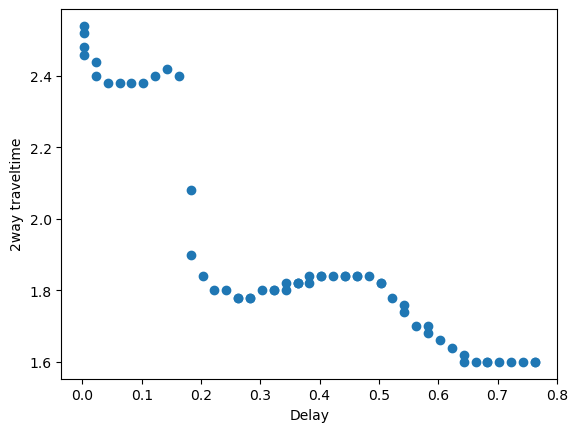

In [20]:
plt.scatter(delays, travel_times)
plt.xlabel("Delay")
plt.ylabel("2way traveltime")